Building on our initial exploration, we be more quantitative and try to reproduce something like Fig. 2a in the paper, or at least a portion of it subject to the annealing times we can access. We copy the necessary imports and function definitions:

In [1]:
from dwave.system import EmbeddingComposite, DWaveSampler
import networkx as nx # For drawing graphs
import matplotlib.pyplot as plt
import numpy as np

def anneal_1d_chain(J_val, N, ta, n_reads):
    # Construct dictionaries for qubit biases and couplers:
    h = {} # No biases needed
    J = {} # Coupler dictionary
    for i in range(N):
        key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
        J[key_tuple] = J_val
    sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding
    samples = sampler.sample_ising(h, J, num_reads=n_reads, label='Anneal spin chain from paper', annealing_time=ta) # Do a single anneal

    return samples

def draw_chain(N, spins):
    plt.figure()
    G = nx.Graph()
    G.add_nodes_from(range(N), spin=spins) # Add spins to graph
    for i in range(N):
        G.add_edge(i, (i + 1) % N)

    nx.draw_circular(G, cmap=plt.get_cmap('bwr'), node_color=spins, node_size=100)

Now we vary the annealing time for a fixed chain length and coupling strength:

In [2]:
import csv

ta = np.logspace(0, 3) #np.linspace(0.5, 2000, 10) # Annealing times in us
J = 1
N = 512
n_reads = 100

def calc_kink_density(sample):
    kink_count = len([x for x in range(1, len(sample)) if sample[x] != sample[x - 1]]) 
    kink_density = kink_count/len(sample)
    return kink_density

average_kink_densities = []
for time in ta:
    samples = anneal_1d_chain(J, N, time, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('ta.csv', ta, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'n_reads': n_reads}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

Text(0, 0.5, 'Average kink density')

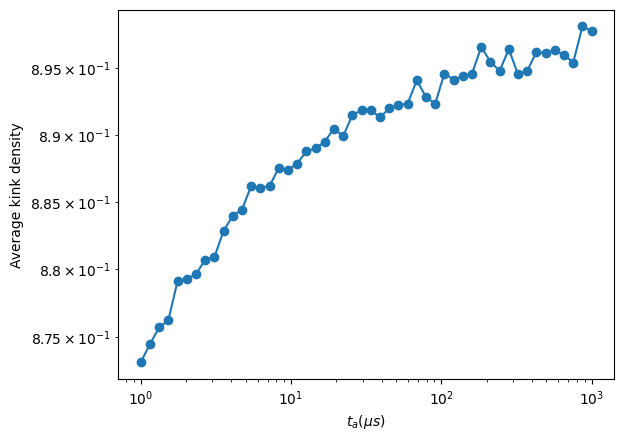

In [3]:
plt.plot(ta, average_kink_densities, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_a (\mu s)$')
plt.ylabel('Average kink density')

It is not clear that this is working - comparing to Fig. 2 qualitatively in the appropriate annealing time regime, we do indeed see some plateauing increase in the average kink density, but not the decrease after that we would expect, especially as we anneal over longer times than that plot. We have comparable parameters and the code should be working, so it is not clear why the data give such a mixed picture. Let's investigate more parameter values, firstly the number of reads, but also the coupler strength and chain length. We'll also decrease the number of points to save some computational time.

In [2]:
import csv

ta = np.geomspace(0.5, 700, num=15) #np.geomspace(0.5, 2000, num=30) # Annealing times in us
J = 1
N = 512
n_reads = 2000

def calc_kink_density(sample):
    kink_count = len([x for x in range(1, len(sample)) if sample[x] != sample[x - 1]]) 
    kink_density = kink_count/len(sample)
    return kink_density

average_kink_densities = []
for time in ta:
    print('Annealing time = {} us'.format(time))
    samples = anneal_1d_chain(J, N, time, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('ta.csv', ta, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'n_reads': n_reads}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

plt.plot(ta, average_kink_densities, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_a (\mu s)$')
plt.ylabel('Average kink density')
plt.savefig('av kink density vs. anneal time.png')
plt.savefig('av kink density vs. anneal time.eps')

Annealing time = 0.5 us
Annealing time = 0.8388676284073245 us
Annealing time = 1.4073977959794584 us
Annealing time = 2.361240902677968 us
Annealing time = 3.9615371122556744 us
Annealing time = 6.646410484411035 us
Annealing time = 11.150917200958927 us
Annealing time = 18.708286933869708 us
Annealing time = 31.387552583558044 us
Annealing time = 52.66000359455907 us
Annealing time = 88.34954465457788 us
Annealing time = 148.22714599050548 us
Annealing time = 248.68590884528336 us
Annealing time = 417.2291171427258 us


SolverFailureError: The problem cannot be submitted because its estimated QPU access time of 1320281 microseconds exceeds the maximum of 1000000 microseconds for Advantage_system4.1. To resolve this issue, see the topic at https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#keeping-within-the-runtime-limit.

We also check more carefully whether we are converged with respect to the number of reads for a given annealing time (does the annealing time matter?)

In [7]:
n_reads_list = [1, 10, 100, 1000, 2000, 3000, 5000, 10000]
ta = 0.5 # In us

average_kink_densities = []
for n_reads in n_reads_list:
    print('n_reads = {}'.format(n_reads))
    samples = anneal_1d_chain(J, N, ta, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('n_reads.csv', n_reads_list, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'ta': ta}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

plt.plot(n_reads_list, average_kink_densities, '-o')
plt.xlabel('n_reads')
plt.ylabel('Average kink density')
plt.savefig('av kink density vs. n_reads.png')
plt.savefig('av kink density vs. n_reads.eps')

n_reads = 1
n_reads = 10
n_reads = 100
n_reads = 1000
n_reads = 2000
n_reads = 3000
n_reads = 5000


SolverFailureError: The problem cannot be submitted because its estimated QPU access time of 1195327 microseconds exceeds the maximum of 1000000 microseconds for Advantage_system4.1. To resolve this issue, see the topic at https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#keeping-within-the-runtime-limit.